In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from meteostat import Stations, Hourly
from datetime import datetime
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

In [120]:
df_2020 = pd.read_excel("C:/Users/ivan_/OneDrive/Desktop/Energy consumption data/Energy consumption 2020.xlsx")
df_2021 = pd.read_excel("C:/Users/ivan_/OneDrive/Desktop/Energy consumption data/Energy consumption 2021.xlsx")
df_2022 = pd.read_excel("C:/Users/ivan_/OneDrive/Desktop/Energy consumption data/Energy consumption 2022.xlsx")
df_2023 = pd.read_excel("C:/Users/ivan_/OneDrive/Desktop/Energy consumption data/Energy consumption 2023.xlsx")
df_2024 = pd.read_excel("C:/Users/ivan_/OneDrive/Desktop/Energy consumption data/Energy consumption 2024.xlsx")

In [121]:
df_all = pd.concat([df_2020, df_2021, df_2022, df_2023, df_2024], ignore_index=True)

In [122]:
df_all

,Date,Total Load [MW],Forecast Total Load [MW],Bidding Zone
0,2020-12-31 23:45:00,1018.133,1027.439,Sardinia
1,2020-12-31 23:30:00,1040.178,1055.560,Sardinia
2,2020-12-31 23:15:00,1045.089,1070.311,Sardinia
3,2020-12-31 23:00:00,1042.968,1068.360,Sardinia
4,2020-12-31 22:45:00,1061.341,1076.729,Sardinia
...,...,...,...,...
175397,2024-01-01 00:30:00,796.119,800.748,Sardinia
175398,2024-01-01 00:15:00,801.821,804.419,Sardinia
175399,2024-01-01 00:00:00,814.730,819.870,Sardinia
175400,NaN,NaN,NaN,NaN


In [123]:
df_all.isnull().sum()

Date                         5
Total Load [MW]             10
Forecast Total Load [MW]    10
Bidding Zone                10
dtype: int64

In [124]:
df_all = df_all.dropna()

In [125]:
df_all.isnull().sum()

Date                        0
Total Load [MW]             0
Forecast Total Load [MW]    0
Bidding Zone                0
dtype: int64

In [126]:
df_all.duplicated().sum()

np.int64(0)

In [127]:
# Convert 'Date' column to datetime
df_all['Date'] = pd.to_datetime(df_all['Date'], errors='coerce')

# Drop any rows where conversion failed
df_all = df_all.dropna(subset=['Date'])

# Set 'Date' as the index
df_all.set_index('Date', inplace=True)

# Sort by datetime
df_all.sort_index(inplace=True)

C:\Users\ivan_\AppData\Local\Temp\ipykernel_17752\2056619303.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [128]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175392 entries, 2020-01-01 00:00:00 to 2024-12-31 23:45:00
Data columns (total 3 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Total Load [MW]           175392 non-null  float64
 1   Forecast Total Load [MW]  175392 non-null  float64
 2   Bidding Zone              175392 non-null  object 
dtypes: float64(2), object(1)
memory usage: 5.4+ MB


In [129]:
df_all.shape

(175392, 3)

In [130]:
df_all['Year'] = df_all.index.year
df_all['Month'] = df_all.index.month
df_all['Day'] = df_all.index.day
df_all['Weekday'] = df_all.index.weekday  # Monday=0, Sunday=6
df_all['Hour'] = df_all.index.hour
df_all['Minute'] = df_all.index.minute

In [131]:
df_all.head()

,Total Load [MW],Forecast Total Load [MW],Bidding Zone,Year,Month,Day,Weekday,Hour,Minute
Date,,,,,,,,,
2020-01-01 00:00:00,908.259,915.846,Sardinia,2020,1,1,2,0,0
2020-01-01 00:15:00,918.506,935.880,Sardinia,2020,1,1,2,0,15
2020-01-01 00:30:00,906.034,925.482,Sardinia,2020,1,1,2,0,30
2020-01-01 00:45:00,902.065,920.354,Sardinia,2020,1,1,2,0,45
2020-01-01 01:00:00,902.502,912.763,Sardinia,2020,1,1,2,1,0


In [132]:
df_all['Error'] = df_all['Forecast Total Load [MW]'] - df_all['Total Load [MW]']
df_all['Absolute Error'] = df_all['Error'].abs()
df_all['Percentage Error'] = df_all['Absolute Error'] / df_all['Total Load [MW]'] * 100

In [133]:
df_all

,Total Load [MW],Forecast Total Load [MW],Bidding Zone,Year,Month,Day,Weekday,Hour,Minute,Error,Absolute Error,Percentage Error
Date,,,,,,,,,,,,
2020-01-01 00:00:00,908.259,915.846,Sardinia,2020,1,1,2,0,0,7.587,7.587,0.835334
2020-01-01 00:15:00,918.506,935.880,Sardinia,2020,1,1,2,0,15,17.374,17.374,1.891550
2020-01-01 00:30:00,906.034,925.482,Sardinia,2020,1,1,2,0,30,19.448,19.448,2.146498
2020-01-01 00:45:00,902.065,920.354,Sardinia,2020,1,1,2,0,45,18.289,18.289,2.027459
2020-01-01 01:00:00,902.502,912.763,Sardinia,2020,1,1,2,1,0,10.261,10.261,1.136950
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 22:45:00,954.995,993.698,Sardinia,2024,12,31,1,22,45,38.703,38.703,4.052691
2024-12-31 23:00:00,943.133,979.461,Sardinia,2024,12,31,1,23,0,36.328,36.328,3.851843
2024-12-31 23:15:00,932.153,964.675,Sardinia,2024,12,31,1,23,15,32.522,32.522,3.488912


In [134]:
mae = mean_absolute_error(df_all['Total Load [MW]'], df_all['Forecast Total Load [MW]'])
rmse = np.sqrt(mean_squared_error(df_all['Total Load [MW]'], df_all['Forecast Total Load [MW]']))
mape = df_all['Percentage Error'].mean()

print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}%")

MAE: 21.406338116903854, RMSE: 28.136634376499927, MAPE: 2.1544534256713392%


In [135]:
# Average error by hour
hourly_error = df_all.groupby('Hour')['Absolute Error'].mean()
print(hourly_error)

# Average error by weekday
weekday_error = df_all.groupby('Weekday')['Absolute Error'].mean()
print(weekday_error)

# Average error by month
monthly_error = df_all.groupby('Month')['Absolute Error'].mean()
print(monthly_error)


Hour
0     21.180619
1     19.358612
2     16.345471
3     14.604242
4     13.254772
5     13.687535
6     20.799171
7     23.662812
8     23.191288
9     21.402495
10    24.615846
11    27.086689
12    29.872334
13    27.023599
14    23.498439
15    22.404419
16    20.443900
17    21.991984
18    22.157750
19    21.731347
20    20.122154
21    21.236760
22    22.973145
23    21.106733
Name: Absolute Error, dtype: float64
Weekday
0    23.986702
1    21.603047
2    20.083483
3    20.570007
4    21.277160
5    22.028955
6    20.295012
Name: Absolute Error, dtype: float64
Month
1     21.697331
2     20.851087
3     20.845379
4     23.097118
5     20.751627
6     18.752833
7     22.850491
8     28.535525
9     20.173595
10    17.430313
11    18.643306
12    23.045518
Name: Absolute Error, dtype: float64


In [136]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_all['Season'] = df_all['Month'].apply(month_to_season)

In [137]:
season_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3}

df_all['Season'] = df_all['Season'].map(season_mapping)

In [138]:
# Average absolute error by hour
hourly_error = df_all.groupby('Hour')['Absolute Error'].mean()
print(hourly_error)

# Average absolute error by season
season_error = df_all.groupby('Season')['Absolute Error'].mean()
print(season_error)

Hour
0     21.180619
1     19.358612
2     16.345471
3     14.604242
4     13.254772
5     13.687535
6     20.799171
7     23.662812
8     23.191288
9     21.402495
10    24.615846
11    27.086689
12    29.872334
13    27.023599
14    23.498439
15    22.404419
16    20.443900
17    21.991984
18    22.157750
19    21.731347
20    20.122154
21    21.236760
22    22.973145
23    21.106733
Name: Absolute Error, dtype: float64
Season
0    21.893797
1    21.548370
2    23.429908
3    18.733983
Name: Absolute Error, dtype: float64


In [139]:
season_error = df_all.groupby('Season')['Absolute Error'].mean()
print("Average Absolute Error by Season:")
print(season_error)

Average Absolute Error by Season:
Season
0    21.893797
1    21.548370
2    23.429908
3    18.733983
Name: Absolute Error, dtype: float64


In [140]:
# Search for stations near Cagliari, Sardinia
stations = Stations()
stations = stations.nearby(39.2238, 9.1217)  # Latitude, Longitude
station = stations.fetch(1)  # Get the closest station
print(station)

                   name country region    wmo  icao  latitude  longitude  \
id                                                                         
16560  Cagliari / Elmas      IT     SD  16560  LIEE     39.25     9.0667   

       elevation     timezone hourly_start hourly_end daily_start  daily_end  \
id                                                                             
16560        4.0  Europe/Rome   1943-11-01 2025-09-10  1943-11-01 2025-08-24   

      monthly_start monthly_end     distance  
id                                            
16560    1943-01-01  2022-01-01  5561.037783  


In [141]:
start = datetime(2020, 1, 1)
end = datetime(2024, 12, 31)

# Get hourly weather data
data = Hourly(station.index[0], start, end)
data = data.fetch()

In [142]:
data.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2020-01-01 00:00:00,3.8,3.1,95.0,<NA>,<NA>,270.0,5.4,13.0,1031.5,<NA>,1.0
2020-01-01 01:00:00,4.0,3.0,93.0,<NA>,<NA>,280.0,5.4,13.0,1031.0,<NA>,1.0
2020-01-01 02:00:00,4.0,3.0,93.0,<NA>,<NA>,290.0,5.4,14.8,1031.0,<NA>,1.0
2020-01-01 03:00:00,3.6,3.0,96.0,<NA>,<NA>,330.0,1.8,13.0,1031.4,<NA>,1.0
2020-01-01 04:00:00,3.0,3.0,100.0,<NA>,<NA>,330.0,11.2,13.0,1030.0,<NA>,1.0


In [143]:
# Assuming df_all is your electricity load DataFrame with datetime index
df_all.index = pd.to_datetime(df_all.index)

# Resample weather data to match 15-min frequency if needed
weather_resampled = data.resample('15T').ffill()

# Merge datasets
df_all = df_all.join(weather_resampled, how='left')

# Fill missing values if any
df_all.fillna(method='ffill', inplace=True)

C:\Users\ivan_\AppData\Local\Temp\ipykernel_17752\1695881168.py:5: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\ivan_\AppData\Local\Temp\ipykernel_17752\1695881168.py:11: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [144]:
df_all

,Total Load [MW],Forecast Total Load [MW],Bidding Zone,Year,Month,Day,Weekday,Hour,Minute,Error,...,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
2020-01-01 00:00:00,908.259,915.846,Sardinia,2020,1,1,2,0,0,7.587,...,3.1,95.0,<NA>,<NA>,270.0,5.4,13.0,1031.5,<NA>,1.0
2020-01-01 00:15:00,918.506,935.880,Sardinia,2020,1,1,2,0,15,17.374,...,3.1,95.0,<NA>,<NA>,270.0,5.4,13.0,1031.5,<NA>,1.0
2020-01-01 00:30:00,906.034,925.482,Sardinia,2020,1,1,2,0,30,19.448,...,3.1,95.0,<NA>,<NA>,270.0,5.4,13.0,1031.5,<NA>,1.0
2020-01-01 00:45:00,902.065,920.354,Sardinia,2020,1,1,2,0,45,18.289,...,3.1,95.0,<NA>,<NA>,270.0,5.4,13.0,1031.5,<NA>,1.0
2020-01-01 01:00:00,902.502,912.763,Sardinia,2020,1,1,2,1,0,10.261,...,3.0,93.0,<NA>,<NA>,280.0,5.4,13.0,1031.0,<NA>,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 22:45:00,954.995,993.698,Sardinia,2024,12,31,1,22,45,38.703,...,4.6,97.0,0.0,<NA>,350.0,7.6,11.1,1031.0,0.0,5.0
2024-12-31 23:00:00,943.133,979.461,Sardinia,2024,12,31,1,23,0,36.328,...,4.6,97.0,0.0,<NA>,350.0,7.6,11.1,1031.0,0.0,5.0
2024-12-31 23:15:00,932.153,964.675,Sardinia,2024,12,31,1,23,15,32.522,...,4.6,97.0,0.0,<NA>,350.0,7.6,11.1,1031.0,0.0,5.0
2024-12-31 23:30:00,923.055,950.918,Sardinia,2024,12,31,1,23,30,27.863,...,4.6,97.0,0.0,<NA>,350.0,7.6,11.1,1031.0,0.0,5.0


In [145]:
df_all.isnull().sum()

Total Load [MW]                  0
Forecast Total Load [MW]         0
Bidding Zone                     0
Year                             0
Month                            0
Day                              0
Weekday                          0
Hour                             0
Minute                           0
Error                            0
Absolute Error                   0
Percentage Error                 0
Season                           0
temp                             0
dwpt                             0
rhum                             0
prcp                         84188
snow                        175392
wdir                             0
wspd                             0
wpgt                             0
pres                             0
tsun                         91356
coco                             0
dtype: int64

In [146]:
df_all.drop(columns=['snow'], inplace=True)
# Fill precipitation with 0 (no rain if missing)
df_all['prcp'].fillna(0, inplace=True)

# Fill sunshine by forward fill
df_all['tsun'].fillna(method='ffill', inplace=True)

C:\Users\ivan_\AppData\Local\Temp\ipykernel_17752\1191251514.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\ivan_\AppData\Local\Temp\ipykernel_17752\1191251514.py:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [147]:
df_all

,Total Load [MW],Forecast Total Load [MW],Bidding Zone,Year,Month,Day,Weekday,Hour,Minute,Error,...,temp,dwpt,rhum,prcp,wdir,wspd,wpgt,pres,tsun,coco
2020-01-01 00:00:00,908.259,915.846,Sardinia,2020,1,1,2,0,0,7.587,...,3.8,3.1,95.0,0.0,270.0,5.4,13.0,1031.5,<NA>,1.0
2020-01-01 00:15:00,918.506,935.880,Sardinia,2020,1,1,2,0,15,17.374,...,3.8,3.1,95.0,0.0,270.0,5.4,13.0,1031.5,<NA>,1.0
2020-01-01 00:30:00,906.034,925.482,Sardinia,2020,1,1,2,0,30,19.448,...,3.8,3.1,95.0,0.0,270.0,5.4,13.0,1031.5,<NA>,1.0
2020-01-01 00:45:00,902.065,920.354,Sardinia,2020,1,1,2,0,45,18.289,...,3.8,3.1,95.0,0.0,270.0,5.4,13.0,1031.5,<NA>,1.0
2020-01-01 01:00:00,902.502,912.763,Sardinia,2020,1,1,2,1,0,10.261,...,4.0,3.0,93.0,0.0,280.0,5.4,13.0,1031.0,<NA>,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 22:45:00,954.995,993.698,Sardinia,2024,12,31,1,22,45,38.703,...,5.0,4.6,97.0,0.0,350.0,7.6,11.1,1031.0,0.0,5.0
2024-12-31 23:00:00,943.133,979.461,Sardinia,2024,12,31,1,23,0,36.328,...,5.0,4.6,97.0,0.0,350.0,7.6,11.1,1031.0,0.0,5.0
2024-12-31 23:15:00,932.153,964.675,Sardinia,2024,12,31,1,23,15,32.522,...,5.0,4.6,97.0,0.0,350.0,7.6,11.1,1031.0,0.0,5.0
2024-12-31 23:30:00,923.055,950.918,Sardinia,2024,12,31,1,23,30,27.863,...,5.0,4.6,97.0,0.0,350.0,7.6,11.1,1031.0,0.0,5.0


In [148]:
df_all.isnull().sum()

Total Load [MW]                 0
Forecast Total Load [MW]        0
Bidding Zone                    0
Year                            0
Month                           0
Day                             0
Weekday                         0
Hour                            0
Minute                          0
Error                           0
Absolute Error                  0
Percentage Error                0
Season                          0
temp                            0
dwpt                            0
rhum                            0
prcp                            0
wdir                            0
wspd                            0
wpgt                            0
pres                            0
tsun                        91356
coco                            0
dtype: int64

In [149]:
df_all['tsun'].fillna(0, inplace=True)

In [150]:
df_all

,Total Load [MW],Forecast Total Load [MW],Bidding Zone,Year,Month,Day,Weekday,Hour,Minute,Error,...,temp,dwpt,rhum,prcp,wdir,wspd,wpgt,pres,tsun,coco
2020-01-01 00:00:00,908.259,915.846,Sardinia,2020,1,1,2,0,0,7.587,...,3.8,3.1,95.0,0.0,270.0,5.4,13.0,1031.5,0.0,1.0
2020-01-01 00:15:00,918.506,935.880,Sardinia,2020,1,1,2,0,15,17.374,...,3.8,3.1,95.0,0.0,270.0,5.4,13.0,1031.5,0.0,1.0
2020-01-01 00:30:00,906.034,925.482,Sardinia,2020,1,1,2,0,30,19.448,...,3.8,3.1,95.0,0.0,270.0,5.4,13.0,1031.5,0.0,1.0
2020-01-01 00:45:00,902.065,920.354,Sardinia,2020,1,1,2,0,45,18.289,...,3.8,3.1,95.0,0.0,270.0,5.4,13.0,1031.5,0.0,1.0
2020-01-01 01:00:00,902.502,912.763,Sardinia,2020,1,1,2,1,0,10.261,...,4.0,3.0,93.0,0.0,280.0,5.4,13.0,1031.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 22:45:00,954.995,993.698,Sardinia,2024,12,31,1,22,45,38.703,...,5.0,4.6,97.0,0.0,350.0,7.6,11.1,1031.0,0.0,5.0
2024-12-31 23:00:00,943.133,979.461,Sardinia,2024,12,31,1,23,0,36.328,...,5.0,4.6,97.0,0.0,350.0,7.6,11.1,1031.0,0.0,5.0
2024-12-31 23:15:00,932.153,964.675,Sardinia,2024,12,31,1,23,15,32.522,...,5.0,4.6,97.0,0.0,350.0,7.6,11.1,1031.0,0.0,5.0
2024-12-31 23:30:00,923.055,950.918,Sardinia,2024,12,31,1,23,30,27.863,...,5.0,4.6,97.0,0.0,350.0,7.6,11.1,1031.0,0.0,5.0


In [151]:
df_all.columns

Index(['Total Load [MW]', 'Forecast Total Load [MW]', 'Bidding Zone', 'Year',
       'Month', 'Day', 'Weekday', 'Hour', 'Minute', 'Error', 'Absolute Error',
       'Percentage Error', 'Season', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir',
       'wspd', 'wpgt', 'pres', 'tsun', 'coco'],
      dtype='object')

In [152]:
# Rename weather columns
df_all.rename(columns={
    'temp': 'temperature',
    'dwpt': 'dew_point',
    'rhum': 'humidity',
    'prcp': 'precipitation',
    'wdir': 'wind_direction',
    'wspd': 'wind_speed',
    'wpgt': 'wind_gust',
    'pres': 'pressure',
    'tsun': 'sunshine',
    'coco': 'weather_code'
}, inplace=True)


In [153]:
df_all

,Total Load [MW],Forecast Total Load [MW],Bidding Zone,Year,Month,Day,Weekday,Hour,Minute,Error,...,temperature,dew_point,humidity,precipitation,wind_direction,wind_speed,wind_gust,pressure,sunshine,weather_code
2020-01-01 00:00:00,908.259,915.846,Sardinia,2020,1,1,2,0,0,7.587,...,3.8,3.1,95.0,0.0,270.0,5.4,13.0,1031.5,0.0,1.0
2020-01-01 00:15:00,918.506,935.880,Sardinia,2020,1,1,2,0,15,17.374,...,3.8,3.1,95.0,0.0,270.0,5.4,13.0,1031.5,0.0,1.0
2020-01-01 00:30:00,906.034,925.482,Sardinia,2020,1,1,2,0,30,19.448,...,3.8,3.1,95.0,0.0,270.0,5.4,13.0,1031.5,0.0,1.0
2020-01-01 00:45:00,902.065,920.354,Sardinia,2020,1,1,2,0,45,18.289,...,3.8,3.1,95.0,0.0,270.0,5.4,13.0,1031.5,0.0,1.0
2020-01-01 01:00:00,902.502,912.763,Sardinia,2020,1,1,2,1,0,10.261,...,4.0,3.0,93.0,0.0,280.0,5.4,13.0,1031.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 22:45:00,954.995,993.698,Sardinia,2024,12,31,1,22,45,38.703,...,5.0,4.6,97.0,0.0,350.0,7.6,11.1,1031.0,0.0,5.0
2024-12-31 23:00:00,943.133,979.461,Sardinia,2024,12,31,1,23,0,36.328,...,5.0,4.6,97.0,0.0,350.0,7.6,11.1,1031.0,0.0,5.0
2024-12-31 23:15:00,932.153,964.675,Sardinia,2024,12,31,1,23,15,32.522,...,5.0,4.6,97.0,0.0,350.0,7.6,11.1,1031.0,0.0,5.0
2024-12-31 23:30:00,923.055,950.918,Sardinia,2024,12,31,1,23,30,27.863,...,5.0,4.6,97.0,0.0,350.0,7.6,11.1,1031.0,0.0,5.0


In [154]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175392 entries, 2020-01-01 00:00:00 to 2024-12-31 23:45:00
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Total Load [MW]           175392 non-null  float64
 1   Forecast Total Load [MW]  175392 non-null  float64
 2   Bidding Zone              175392 non-null  object 
 3   Year                      175392 non-null  int32  
 4   Month                     175392 non-null  int32  
 5   Day                       175392 non-null  int32  
 6   Weekday                   175392 non-null  int32  
 7   Hour                      175392 non-null  int32  
 8   Minute                    175392 non-null  int32  
 9   Error                     175392 non-null  float64
 10  Absolute Error            175392 non-null  float64
 11  Percentage Error          175392 non-null  float64
 12  Season                    175392 non-null  int64  
 13  temperatur

In [155]:
df_all.describe()

,Total Load [MW],Forecast Total Load [MW],Year,Month,Day,Weekday,Hour,Minute,Error,Absolute Error,...,temperature,dew_point,humidity,precipitation,wind_direction,wind_speed,wind_gust,pressure,sunshine,weather_code
count,175392.000000,175392.000000,175392.000000,175392.000000,175392.000000,175392.000000,175392.000000,175392.000000,175392.000000,175392.000000,...,175392.0,175392.0,175392.0,175392.0,175392.0,175392.0,175392.0,175392.0,175392.0,175392.0
mean,994.608846,1000.184520,2022.000000,6.521871,15.735108,3.000000,11.500000,22.500000,5.575673,21.406338,...,18.11606,12.741808,73.646187,0.019278,241.410942,13.501797,23.307261,1016.4816,8.010878,2.080619
std,174.513518,175.374382,1.414991,3.449217,8.802460,2.000006,6.922206,16.770558,27.578731,18.260361,...,7.193574,5.509576,17.41669,0.195365,112.028883,7.670531,10.070584,6.414809,16.375216,2.149872
min,581.207000,580.226000,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-192.318000,0.000000,...,-1.1,-6.6,10.0,0.0,0.0,0.0,3.7,993.0,0.0,0.0
25%,859.823750,864.094250,2021.000000,4.000000,8.000000,1.000000,5.750000,11.250000,-10.376250,7.989000,...,13.0,8.9,62.0,0.0,160.0,7.6,14.8,1012.5,0.0,1.0
50%,995.587500,1000.070000,2022.000000,7.000000,16.000000,3.000000,11.500000,22.500000,6.270000,16.949000,...,17.8,12.8,76.0,0.0,300.0,11.2,20.4,1016.0,0.0,2.0
75%,1120.444500,1125.408250,2023.000000,10.000000,23.000000,5.000000,17.250000,33.750000,21.640250,29.789000,...,23.5,17.0,88.0,0.0,340.0,18.4,27.8,1020.1,3.0,2.0
max,1956.725000,1897.173000,2024.000000,12.000000,31.000000,6.000000,23.000000,45.000000,192.725000,192.725000,...,43.8,26.9,100.0,11.0,360.0,92.5,79.6,1038.3,60.0,26.0


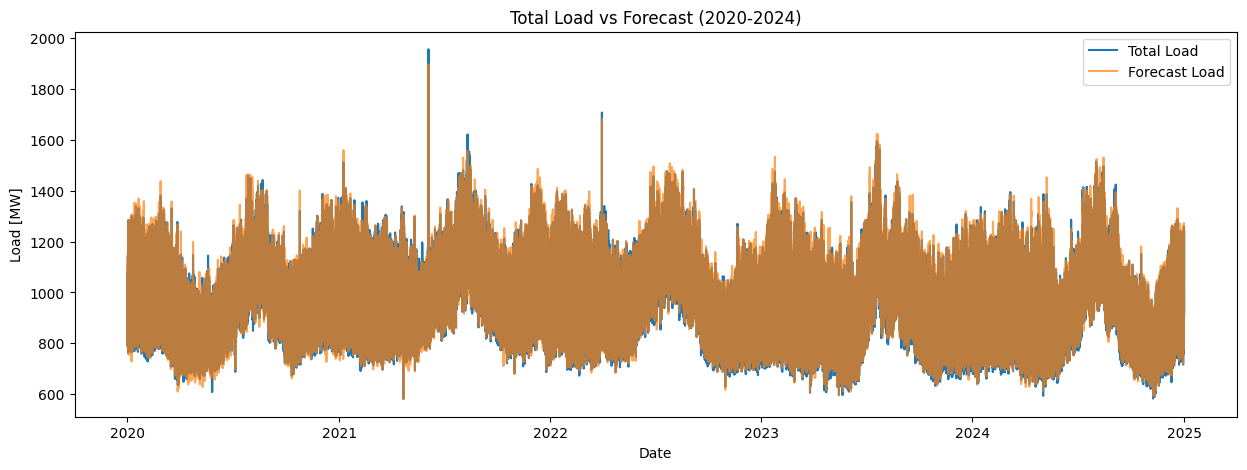

In [156]:
plt.figure(figsize=(15,5))
plt.plot(df_all['Total Load [MW]'], label='Total Load')
plt.plot(df_all['Forecast Total Load [MW]'], label='Forecast Load', alpha=0.7)
plt.title('Total Load vs Forecast (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Load [MW]')
plt.legend()
plt.show()

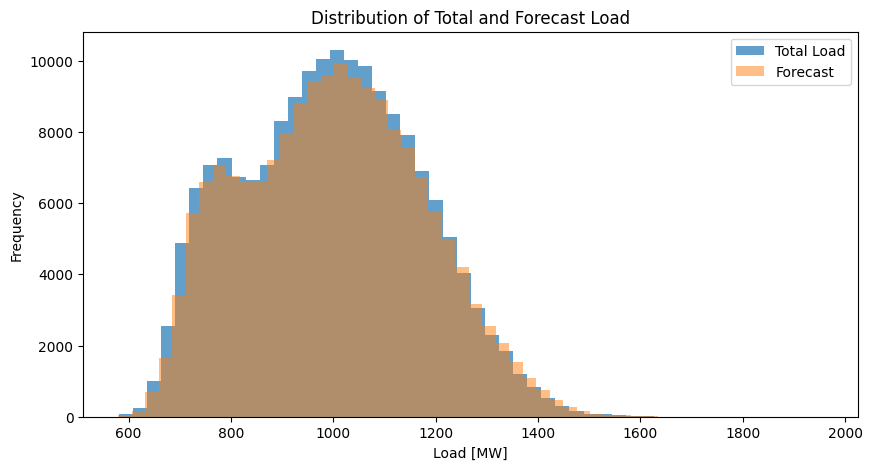

In [157]:
plt.figure(figsize=(10,5))
plt.hist(df_all['Total Load [MW]'], bins=50, alpha=0.7, label='Total Load')
plt.hist(df_all['Forecast Total Load [MW]'], bins=50, alpha=0.5, label='Forecast')
plt.title('Distribution of Total and Forecast Load')
plt.xlabel('Load [MW]')
plt.ylabel('Frequency')
plt.legend()
plt.show()

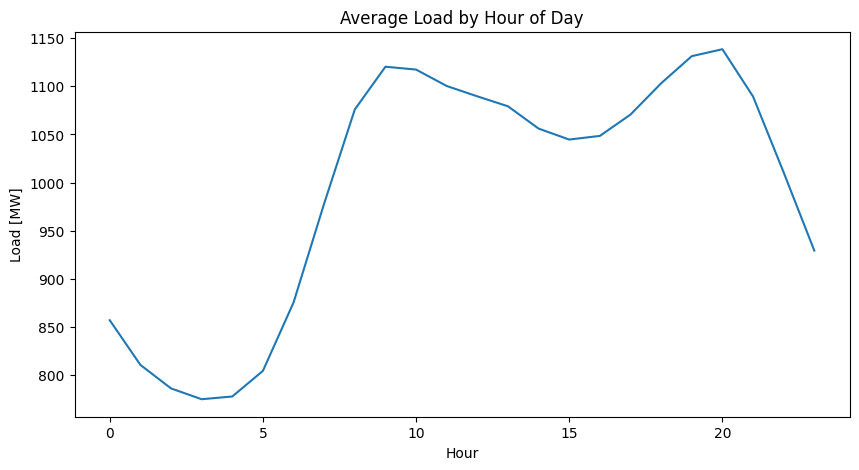

In [158]:
hourly_avg = df_all.groupby('Hour')['Total Load [MW]'].mean()
plt.figure(figsize=(10,5))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values)
plt.title('Average Load by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Load [MW]')
plt.show()

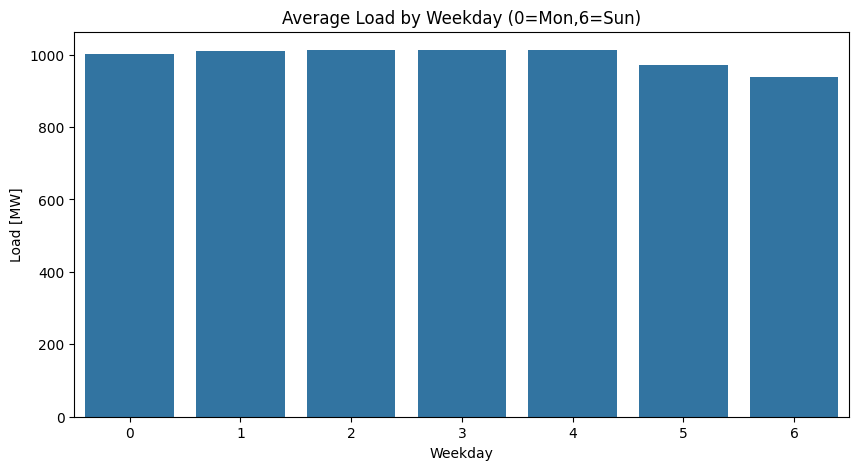

In [159]:
weekday_avg = df_all.groupby('Weekday')['Total Load [MW]'].mean()
plt.figure(figsize=(10,5))
sns.barplot(x=weekday_avg.index, y=weekday_avg.values)
plt.title('Average Load by Weekday (0=Mon,6=Sun)')
plt.xlabel('Weekday')
plt.ylabel('Load [MW]')
plt.show()

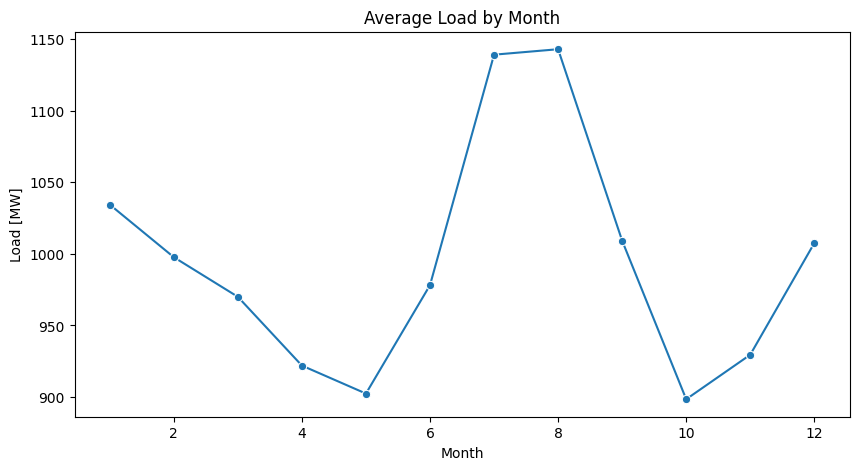

In [160]:
monthly_avg = df_all.groupby('Month')['Total Load [MW]'].mean()
plt.figure(figsize=(10,5))
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values, marker='o')
plt.title('Average Load by Month')
plt.xlabel('Month')
plt.ylabel('Load [MW]')
plt.show()

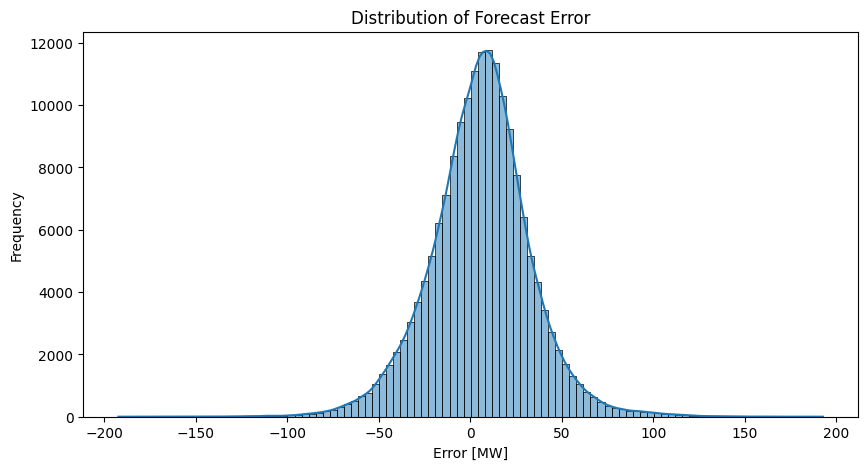

In [161]:
plt.figure(figsize=(10,5))
sns.histplot(df_all['Error'], bins=100, kde=True)
plt.title('Distribution of Forecast Error')
plt.xlabel('Error [MW]')
plt.ylabel('Frequency')
plt.show()

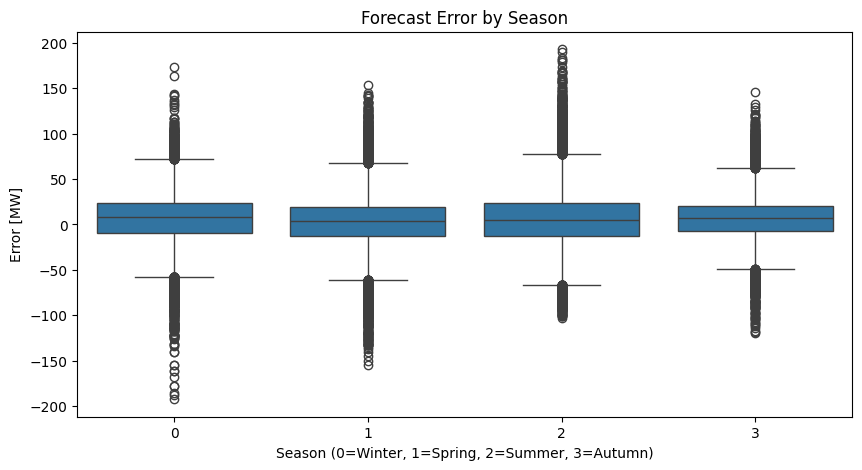

In [162]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Season', y='Error', data=df_all)
plt.title('Forecast Error by Season')
plt.xlabel('Season (0=Winter, 1=Spring, 2=Summer, 3=Autumn)')
plt.ylabel('Error [MW]')
plt.show()

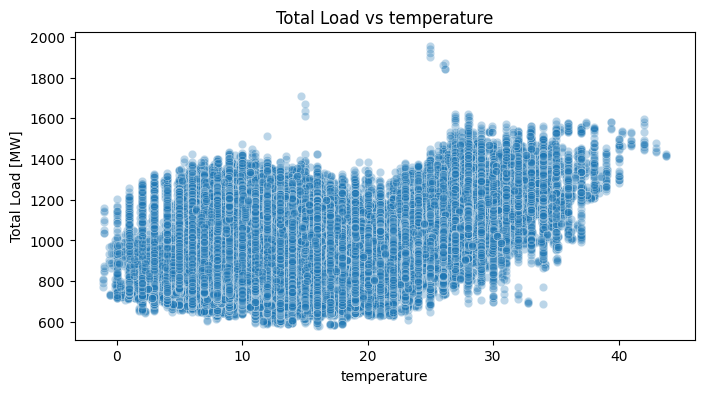

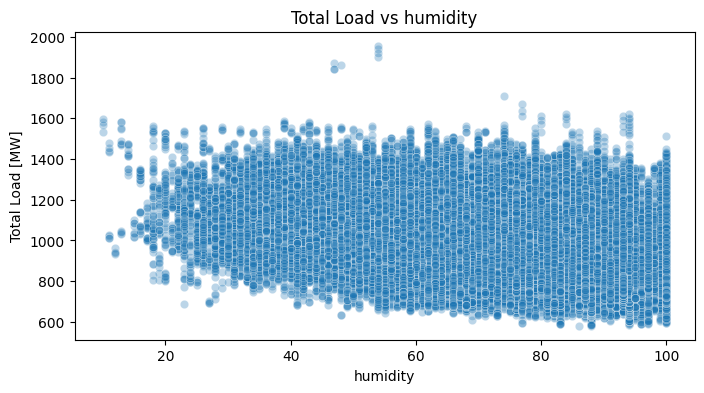

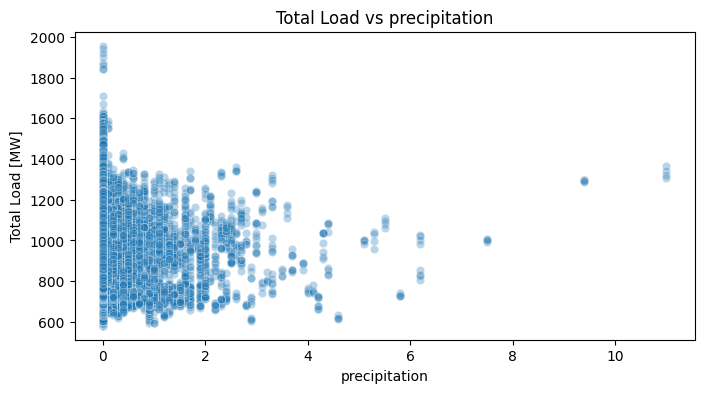

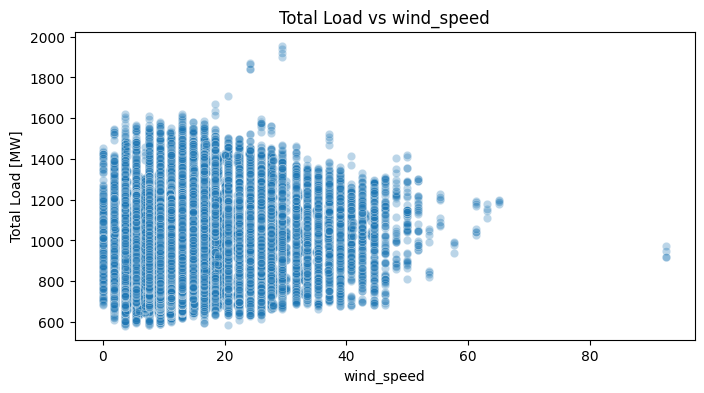

In [163]:
weather_features = ['temperature', 'humidity', 'precipitation', 'wind_speed']

for feature in weather_features:
    plt.figure(figsize=(8,4))
    sns.scatterplot(x=df_all[feature], y=df_all['Total Load [MW]'], alpha=0.3)
    plt.title(f'Total Load vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Total Load [MW]')
    plt.show()

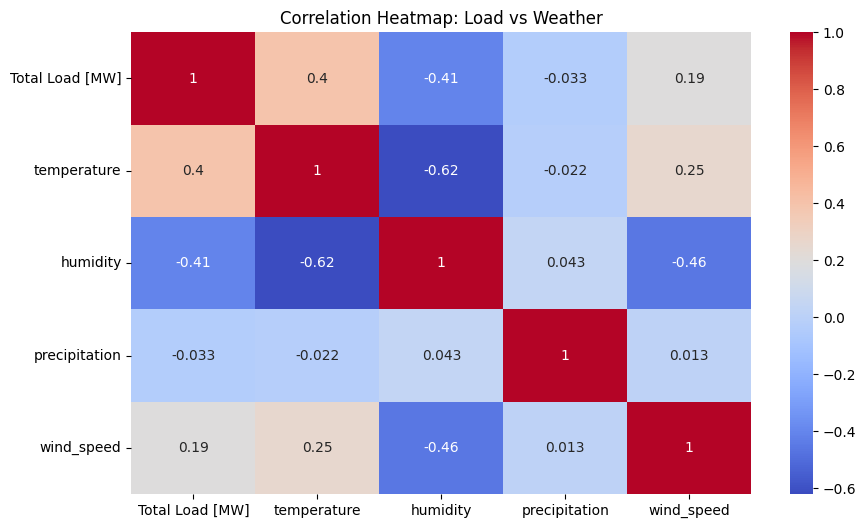

In [164]:
plt.figure(figsize=(10,6))
sns.heatmap(df_all[['Total Load [MW]','temperature','humidity','precipitation','wind_speed']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: Load vs Weather')
plt.show()

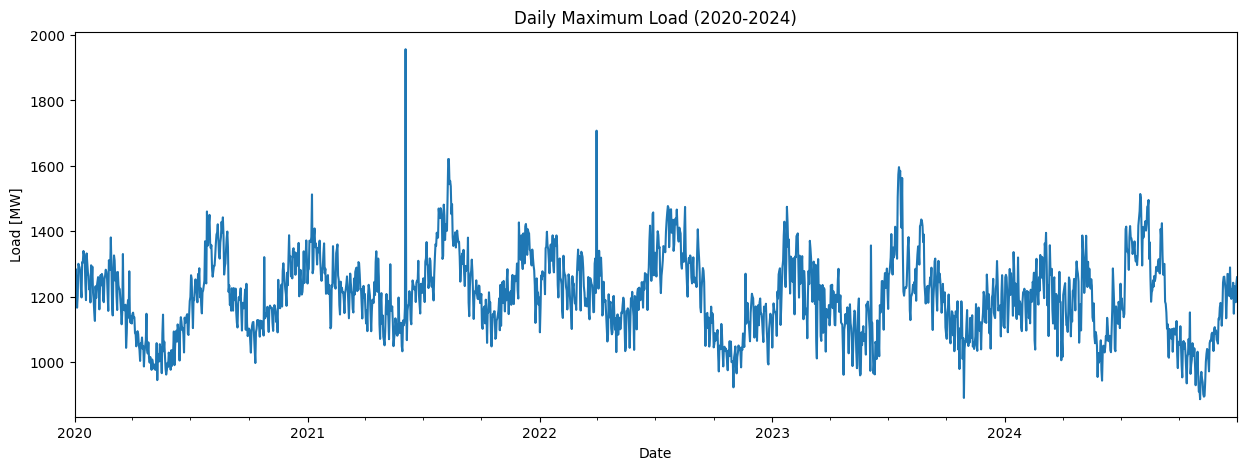

In [165]:
daily_max = df_all['Total Load [MW]'].resample('D').max()
plt.figure(figsize=(15,5))
daily_max.plot()
plt.title('Daily Maximum Load (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Load [MW]')
plt.show()

In [166]:
# create lag features for 1h, 2h, 3h
df_all['Load_lag1'] = df_all['Total Load [MW]'].shift(1)
df_all['Load_lag2'] = df_all['Total Load [MW]'].shift(2)
df_all['Load_lag3'] = df_all['Total Load [MW]'].shift(3)

In [167]:
# create lag features for 1h, 2h, 3h
df_all['Load_lag1'] = df_all['Total Load [MW]'].shift(1)
df_all['Load_lag2'] = df_all['Total Load [MW]'].shift(2)
df_all['Load_lag3'] = df_all['Total Load [MW]'].shift(3)

In [168]:
df_all.isnull().sum()

Total Load [MW]             0
Forecast Total Load [MW]    0
Bidding Zone                0
Year                        0
Month                       0
Day                         0
Weekday                     0
Hour                        0
Minute                      0
Error                       0
Absolute Error              0
Percentage Error            0
Season                      0
temperature                 0
dew_point                   0
humidity                    0
precipitation               0
wind_direction              0
wind_speed                  0
wind_gust                   0
pressure                    0
sunshine                    0
weather_code                0
Load_lag1                   1
Load_lag2                   2
Load_lag3                   3
dtype: int64

In [169]:
df_all = df_all.dropna(subset=['Load_lag1', 'Load_lag2', 'Load_lag3'])

In [170]:
df_all.isnull().sum()

Total Load [MW]             0
Forecast Total Load [MW]    0
Bidding Zone                0
Year                        0
Month                       0
Day                         0
Weekday                     0
Hour                        0
Minute                      0
Error                       0
Absolute Error              0
Percentage Error            0
Season                      0
temperature                 0
dew_point                   0
humidity                    0
precipitation               0
wind_direction              0
wind_speed                  0
wind_gust                   0
pressure                    0
sunshine                    0
weather_code                0
Load_lag1                   0
Load_lag2                   0
Load_lag3                   0
dtype: int64

In [175]:
df_all = df_all.rename(columns={
    'Total Load [MW]': 'total_load',
    'Forecast Total Load [MW]': 'forecast_load',
    'dew_point': 'dew_point',
    'wind_direction': 'wind_direction',
    'wind_speed': 'wind_speed',
    'wind_gust': 'wind_gust',
    'weather_code': 'weather_code',
    'Load_lag1': 'load_lag1',
    'Load_lag2': 'load_lag2',
    'Load_lag3': 'load_lag3',
})

In [176]:
features = [
    'forecast_load', 'Hour', 'Weekday', 'Month', 'Season',
    'temperature', 'dew_point', 'humidity', 'precipitation', 'wind_direction',
    'wind_speed', 'wind_gust', 'pressure', 'sunshine', 'weather_code',
    'load_lag1', 'load_lag2', 'load_lag3'
]

target = 'total_load'

In [177]:
X = df_all[features]
y = df_all[target]

In [178]:
split_idx = int(len(df_all) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [179]:
lgb_model = LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=42
)

In [180]:
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2308
[LightGBM] [Info] Number of data points in

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [181]:
y_pred = lgb_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [184]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.3f}%")

MAE: 11.187
RMSE: 15.966
MAPE: 1.137%


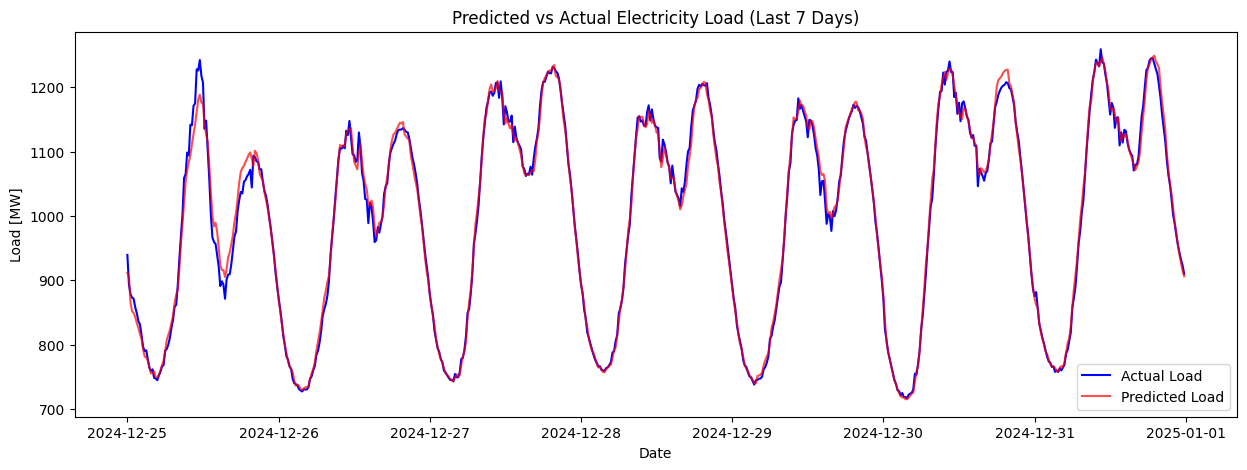

In [185]:
sample_df = df_all[-7*24*4:]  # last 7 days, 15-min intervals
y_true_sample = y_test[-7*24*4:]
y_pred_sample = y_pred[-7*24*4:]

plt.figure(figsize=(15,5))
plt.plot(y_true_sample.index, y_true_sample, label='Actual Load', color='blue')
plt.plot(y_true_sample.index, y_pred_sample, label='Predicted Load', color='red', alpha=0.7)
plt.title("Predicted vs Actual Electricity Load (Last 7 Days)")
plt.xlabel("Date")
plt.ylabel("Load [MW]")
plt.legend()
plt.show()

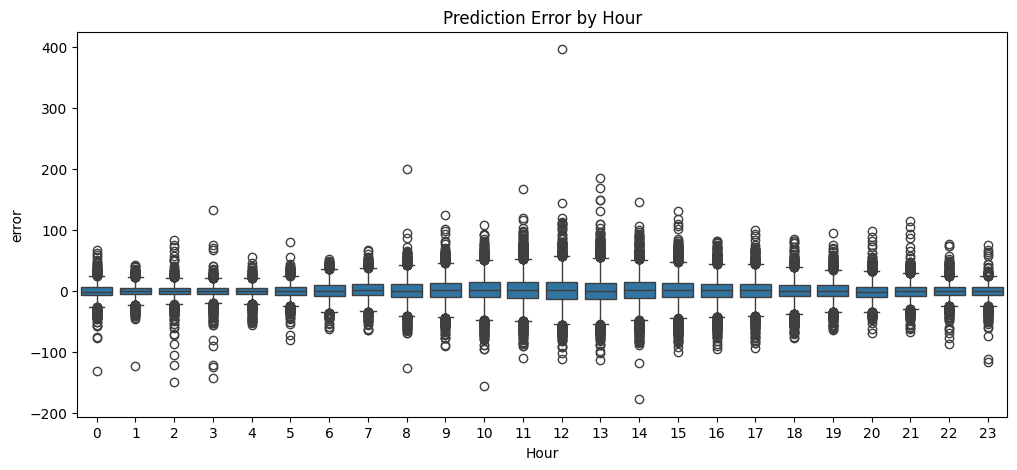

In [188]:
df_all['error'] = df_all['total_load'] - df_all['prediction']

# Boxplot of error by hour
plt.figure(figsize=(12,5))
sns.boxplot(x='Hour', y='error', data=df_all)
plt.title('Prediction Error by Hour')
plt.show()

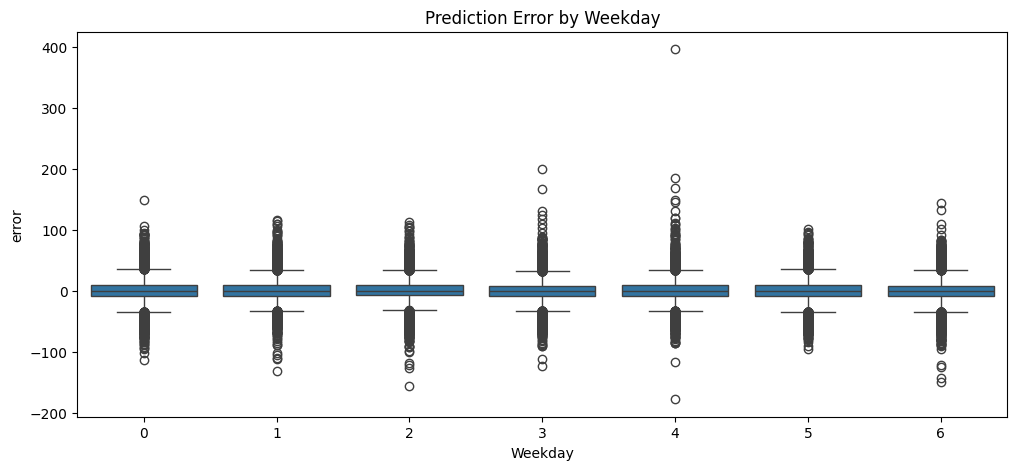

In [189]:
plt.figure(figsize=(12,5))
sns.boxplot(x='Weekday', y='error', data=df_all)
plt.title('Prediction Error by Weekday')
plt.show()

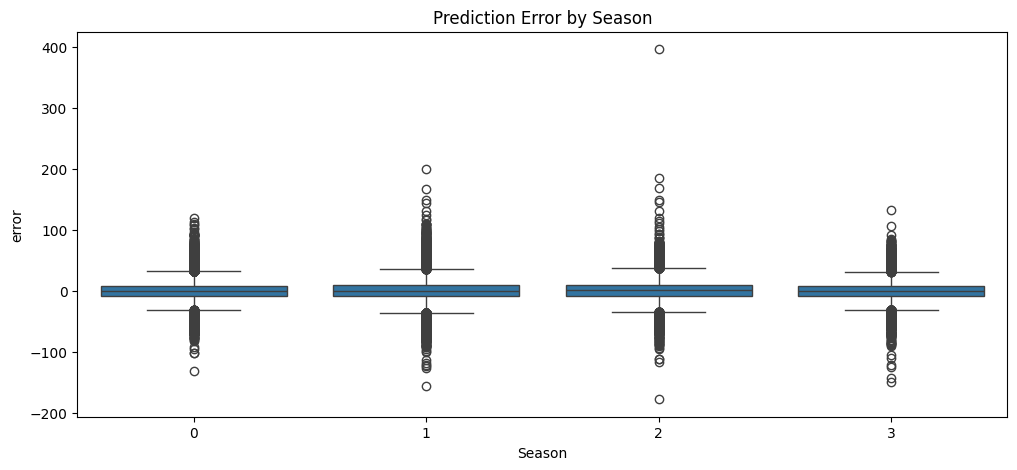

In [190]:
plt.figure(figsize=(12,5))
sns.boxplot(x='Season', y='error', data=df_all)
plt.title('Prediction Error by Season')
plt.show()